In [40]:
import numpy as np
import pandas as pd
import json
import urllib
from os import listdir
from os.path import isfile, join, exists
from sklearn.preprocessing import LabelBinarizer
import mxnet as mx
import logging
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout

np.random.seed(0)
mx.random.seed(0)

BATCH_SIZE = 200

years = xrange(2010, 2018)
table_data_directory = "./data/table"
match_data_directory = "./data/matchdata"

def get_team_name(team, teams):
    if (team not in teams):
        return "unknown"
    else:
        return team

def get_encoder(teams):
    encoder = LabelBinarizer()
    encoder.fit(teams.tolist() + ["unknown"])
    return encoder
    
def encode_team(team, encoder):
    team_name = get_team_name(team, encoder.classes_)
    return encoder.transform([team_name])[0]

def decode_team(team_vector, encoder):
    return encoder.inverse_transform(team_vector)[0]
    
def get_table(year, from_file=True):
    table_result = None
    if (from_file == True):
        table_result = pd.read_json(table_data_directory + "/table" + str(year) + ".txt")
    else:
        url = "https://www.openligadb.de/api/getbltable/bl1/2017"
        response = urllib.urlopen(url)
        data = json.loads(response.read())
        table_result = pd.DataFrame.from_dict(data)
    table_result = table_result[["TeamName"]]
    table_result["Placement"] = table_result.index + 1
    return table_result

def get_team_placement(team, year, from_file=True):
    table = get_table(year, from_file)
    team_placement = table.loc[table["TeamName"] == team.decode('utf-8')]
    if team_placement.empty:
        return 100 # team was not in BL1
    return team_placement["Placement"].values[0]

def compare_placements(placement_team_1, placement_team_2):
    if placement_team_1 < placement_team_2:
        return np.array([1, 0, 0])
    elif placement_team_1 == placement_team_2:
        return np.array([0, 1, 0])
    else:
        return np.array([0, 0, 1])
    
def get_all_teams():
    if (exists("./data/teams.csv")):
        return pd.read_csv("./data/teams.csv", index_col = 0)
    else:
        teams_by_year = []
        for year in years:
            teams_by_year.append(get_table(year)["TeamName"].tolist())

        teams_by_year = np.array(teams_by_year).flatten()
        teams = pd.DataFrame(data = teams_by_year, columns = ["TeamName"]).drop_duplicates().reset_index(drop=True)
        teams.to_csv("./data/teams.csv", encoding='utf-8')
        return pd.read_csv("./data/teams.csv", index_col = 0)
    
def flatten_data_frame(data_frame, column):
    new_data_frame = pd.DataFrame(data_frame[column].values.tolist())
    new_data_frame.columns = new_data_frame.columns.map(lambda x: str(x) + "_" + str(column))
    return data_frame.join(new_data_frame)

def get_team_1(match_json):
    return match_json["Team1"]["TeamName"]

def get_team_2(match_json):
    return match_json["Team2"]["TeamName"]

def get_goals(match_json):
    goals_frame = pd.DataFrame.from_dict(match_json["MatchResults"])
    
    goals_frame = goals_frame.loc[goals_frame["ResultName"] == "Endergebnis"]
    
    return goals_frame[["PointsTeam1", "PointsTeam2"]].values[0]

def get_goals_team_1(match_json):
    goals = get_goals(match_json)
    
    return goals[0]

def get_goals_team_2(match_json):
    goals = get_goals(match_json)
    
    return goals[1]

def get_match_data(match_json):
    return [get_team_1(match_json), get_team_2(match_json), get_goals_team_1(match_json), get_goals_team_2(match_json)]

def parse_match_data(year):
    content = open(match_data_directory + "/matchdata" + str(2010) + ".txt", "r").read()
    content_json = json.loads(content)
    results = []
    for match_json in content_json:
        results.append(get_match_data(match_json) + [year])
        
    return pd.DataFrame(data = np.array(results), columns = ["Team1", "Team2", "GoalsTeam1", "GoalsTeam2", "Year"])

def parse_matches():
    match_data = []
    for year in years:
        match_data.append(parse_match_data(year))
        
    return pd.concat(match_data).reset_index(drop=True)
  
def compare_goals(goals_team_1, goals_team_2):
    if goals_team_1 > goals_team_2:
        return np.array([1, 0, 0])
    elif goals_team_1 == goals_team_2:
        return np.array([0, 1, 0])
    else:
        return np.array([0, 0, 1])
    
encoder = get_encoder(get_all_teams()["TeamName"].values)

def prepare_data():
    if (exists("./data/matches.csv")):
        return pd.read_csv("./data/matches.csv", index_col = 0) 
    else:
        m = parse_matches()

        m["Team1Id"] = [encode_team(team_name.encode('utf-8'), encoder) for team_name in m["Team1"]]
        m["Team1Placement"] = [get_team_placement(team_data[0].encode('utf-8'), team_data[1]) for team_data in m[["Team1", "Year"]].values]
        m["Team2Id"] = [encode_team(team_name.encode('utf-8'), encoder) for team_name in m["Team2"]]
        m["Team2Placement"] = [get_team_placement(team_data[0].encode('utf-8'), team_data[1]) for team_data in m[["Team2", "Year"]].values]
        m["GameResult"] = [compare_goals(goals[0], goals[1]) for goals in m[["GoalsTeam1", "GoalsTeam2"]].values]
        m["Placements"] = [compare_placements(placements[0], placements[1]) for placements in m[["Team1Placement", "Team2Placement"]].values]

        m = flatten_data_frame(m, "Team1Id")
        m = flatten_data_frame(m, "Team2Id")
        m = flatten_data_frame(m, "Placements")
        m = flatten_data_frame(m, "GameResult")

        matches = m.drop(["Team1", "Team2", "GoalsTeam1", "GoalsTeam2", "Year", "Team1Placement", "Team2Placement", "Team1Id", "Team2Id", "Placements", "GameResult"], axis = 1)

        matches.to_csv("./data/matches.csv", encoding='utf-8')
        return matches

loaded_data = prepare_data()
Y = loaded_data[["0_GameResult", "1_GameResult", "2_GameResult"]]
X = loaded_data.drop(["0_GameResult", "1_GameResult", "2_GameResult"], axis = 1)

X_data = X.values
Y_data = Y.values

data_iter = mx.io.NDArrayIter(data=X_data, label=Y_data, batch_size=BATCH_SIZE, shuffle=True)

def train_model(X, Y, evaluation=0.1):
    assert len(X) == len(Y)
    permutation = np.random.permutation(len(X))
    
    X_shuffled = X[permutation]
    Y_shuffled = Y[permutation]
    
    evaluation_index = int(round(0.1 * len(X)))
    
    X_train = X_shuffled[evaluation_index:]
    Y_train = Y_shuffled[evaluation_index:]
    X_test = X_shuffled[:evaluation_index]
    Y_test = Y_shuffled[:evaluation_index]
    
    train_iter = mx.io.NDArrayIter(data=X_train, label=Y_train, batch_size=BATCH_SIZE, shuffle=True)
    test_iter = mx.io.NDArrayIter(data=X_test, label=Y_test, batch_size=BATCH_SIZE, shuffle=True)
    
    data = mx.symbol.Variable("data")
    fc1 = mx.symbol.FullyConnected(data, name="fc1", num_hidden=59)
    act1 = mx.symbol.Activation(fc1, name="relu1", act_type="sigmoid")
    fc2 = mx.symbol.FullyConnected(act1, name="fc2", num_hidden=128)
    act2 = mx.symbol.Activation(fc2, name="relu2", act_type="relu")
    fc3 = mx.symbol.FullyConnected(act2, name="fc3", num_hidden=3)
    softmax = mx.symbol.SoftmaxOutput(fc3, name="softmax") # sets loss function as cross-entropy loss

    context = mx.cpu()
    
    model = mx.mod.Module(symbol=softmax, context=context)
    model.fit(train_iter,
              eval_data=test_iter,
              optimizer='adam',
              optimizer_params={'learning_rate':0.02},
              eval_metric='acc',
              num_epoch=1400)
    model.save_checkpoint("bundesliga_model", 0)
        
    return model

def load_model():
    context = mx.cpu()
    try:
        module = mx.mod.Module.load("bundesliga_model", 0)
        module.bind(data_shapes=[('data', (1, 59))], label_shapes = module._label_shapes)
        return module
    except:
        return None

#train_model(X_data, Y_data)
model = load_model()

def predict_game(model, data):
    test_iter = mx.io.NDArrayIter(data=np.array([data]), label=None, batch_size=1)
    prob = model.predict(test_iter, num_batch=1)[0].asnumpy()
    return prob

def get_game_prediction(model, encoder, team_name_1, team_name_2):
    team_1_id = encode_team(team_name_1, encoder)
    team_2_id = encode_team(team_name_2, encoder)
    print team_1_id
    print team_2_id
    team_1_placement = get_team_placement(team_name_1, 2017, False)
    team_2_placement = get_team_placement(team_name_2, 2017, False)
    placement_comparison = compare_placements(team_1_placement, team_2_placement)
    print placement_comparison
    team_ids = np.append(team_1_id, team_2_id)
    data = np.append(team_ids, placement_comparison)
    return predict_game(model, data)

X = X_data[0]
Y = Y_data[0]

print get_game_prediction(model, encoder, "1. FC Köln", "FC Bayern")
#print get_game_prediction(model, encoder, "TSG 1899 Hoffenheim", "FC Bayern")
#print get_game_prediction(model, encoder, "FC Bayern", "TSG 1899 Hoffenheim")

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1]
[1.000000e+00 3.347804e-09 1.327215e-08]


In [28]:
train_model(X_data, Y_data)

INFO:root:Epoch[0] Train-accuracy=0.666667
INFO:root:Epoch[0] Time cost=0.021
INFO:root:Epoch[0] Validation-accuracy=0.666667
INFO:root:Epoch[1] Train-accuracy=0.666667
INFO:root:Epoch[1] Time cost=0.018
INFO:root:Epoch[1] Validation-accuracy=0.666667
INFO:root:Epoch[2] Train-accuracy=0.666667
INFO:root:Epoch[2] Time cost=0.024
INFO:root:Epoch[2] Validation-accuracy=0.666667
INFO:root:Epoch[3] Train-accuracy=0.666667
INFO:root:Epoch[3] Time cost=0.027
INFO:root:Epoch[3] Validation-accuracy=0.666667
INFO:root:Epoch[4] Train-accuracy=0.666667
INFO:root:Epoch[4] Time cost=0.027
INFO:root:Epoch[4] Validation-accuracy=0.666667
INFO:root:Epoch[5] Train-accuracy=0.666667
INFO:root:Epoch[5] Time cost=0.020
INFO:root:Epoch[5] Validation-accuracy=0.666667
INFO:root:Epoch[6] Train-accuracy=0.666667
INFO:root:Epoch[6] Time cost=0.040
INFO:root:Epoch[6] Validation-accuracy=0.666667
INFO:root:Epoch[7] Train-accuracy=0.666667
INFO:root:Epoch[7] Time cost=0.022
INFO:root:Epoch[7] Validation-accuracy=0

INFO:root:Epoch[64] Train-accuracy=0.680556
INFO:root:Epoch[64] Time cost=0.029
INFO:root:Epoch[64] Validation-accuracy=0.680833
INFO:root:Epoch[65] Train-accuracy=0.681111
INFO:root:Epoch[65] Time cost=0.026
INFO:root:Epoch[65] Validation-accuracy=0.680833
INFO:root:Epoch[66] Train-accuracy=0.682083
INFO:root:Epoch[66] Time cost=0.025
INFO:root:Epoch[66] Validation-accuracy=0.680833
INFO:root:Epoch[67] Train-accuracy=0.682222
INFO:root:Epoch[67] Time cost=0.026
INFO:root:Epoch[67] Validation-accuracy=0.680833
INFO:root:Epoch[68] Train-accuracy=0.682222
INFO:root:Epoch[68] Time cost=0.028
INFO:root:Epoch[68] Validation-accuracy=0.680833
INFO:root:Epoch[69] Train-accuracy=0.682222
INFO:root:Epoch[69] Time cost=0.026
INFO:root:Epoch[69] Validation-accuracy=0.680833
INFO:root:Epoch[70] Train-accuracy=0.682917
INFO:root:Epoch[70] Time cost=0.026
INFO:root:Epoch[70] Validation-accuracy=0.683333
INFO:root:Epoch[71] Train-accuracy=0.683194
INFO:root:Epoch[71] Time cost=0.024
INFO:root:Epoch[7

INFO:root:Epoch[127] Train-accuracy=0.695972
INFO:root:Epoch[127] Time cost=0.029
INFO:root:Epoch[127] Validation-accuracy=0.691667
INFO:root:Epoch[128] Train-accuracy=0.695972
INFO:root:Epoch[128] Time cost=0.028
INFO:root:Epoch[128] Validation-accuracy=0.691667
INFO:root:Epoch[129] Train-accuracy=0.695972
INFO:root:Epoch[129] Time cost=0.028
INFO:root:Epoch[129] Validation-accuracy=0.691667
INFO:root:Epoch[130] Train-accuracy=0.696806
INFO:root:Epoch[130] Time cost=0.028
INFO:root:Epoch[130] Validation-accuracy=0.695000
INFO:root:Epoch[131] Train-accuracy=0.697917
INFO:root:Epoch[131] Time cost=0.029
INFO:root:Epoch[131] Validation-accuracy=0.695000
INFO:root:Epoch[132] Train-accuracy=0.697917
INFO:root:Epoch[132] Time cost=0.025
INFO:root:Epoch[132] Validation-accuracy=0.696667
INFO:root:Epoch[133] Train-accuracy=0.698889
INFO:root:Epoch[133] Time cost=0.028
INFO:root:Epoch[133] Validation-accuracy=0.696667
INFO:root:Epoch[134] Train-accuracy=0.698889
INFO:root:Epoch[134] Time cost=

INFO:root:Epoch[189] Time cost=0.028
INFO:root:Epoch[189] Validation-accuracy=0.699167
INFO:root:Epoch[190] Train-accuracy=0.704583
INFO:root:Epoch[190] Time cost=0.027
INFO:root:Epoch[190] Validation-accuracy=0.699167
INFO:root:Epoch[191] Train-accuracy=0.704583
INFO:root:Epoch[191] Time cost=0.032
INFO:root:Epoch[191] Validation-accuracy=0.699167
INFO:root:Epoch[192] Train-accuracy=0.704583
INFO:root:Epoch[192] Time cost=0.027
INFO:root:Epoch[192] Validation-accuracy=0.699167
INFO:root:Epoch[193] Train-accuracy=0.704583
INFO:root:Epoch[193] Time cost=0.023
INFO:root:Epoch[193] Validation-accuracy=0.699167
INFO:root:Epoch[194] Train-accuracy=0.704583
INFO:root:Epoch[194] Time cost=0.024
INFO:root:Epoch[194] Validation-accuracy=0.699167
INFO:root:Epoch[195] Train-accuracy=0.704583
INFO:root:Epoch[195] Time cost=0.028
INFO:root:Epoch[195] Validation-accuracy=0.699167
INFO:root:Epoch[196] Train-accuracy=0.704583
INFO:root:Epoch[196] Time cost=0.030
INFO:root:Epoch[196] Validation-accurac

INFO:root:Epoch[251] Validation-accuracy=0.705000
INFO:root:Epoch[252] Train-accuracy=0.714028
INFO:root:Epoch[252] Time cost=0.023
INFO:root:Epoch[252] Validation-accuracy=0.705000
INFO:root:Epoch[253] Train-accuracy=0.714028
INFO:root:Epoch[253] Time cost=0.025
INFO:root:Epoch[253] Validation-accuracy=0.705000
INFO:root:Epoch[254] Train-accuracy=0.714028
INFO:root:Epoch[254] Time cost=0.024
INFO:root:Epoch[254] Validation-accuracy=0.705000
INFO:root:Epoch[255] Train-accuracy=0.714028
INFO:root:Epoch[255] Time cost=0.024
INFO:root:Epoch[255] Validation-accuracy=0.705000
INFO:root:Epoch[256] Train-accuracy=0.714028
INFO:root:Epoch[256] Time cost=0.027
INFO:root:Epoch[256] Validation-accuracy=0.705000
INFO:root:Epoch[257] Train-accuracy=0.714028
INFO:root:Epoch[257] Time cost=0.021
INFO:root:Epoch[257] Validation-accuracy=0.705000
INFO:root:Epoch[258] Train-accuracy=0.714028
INFO:root:Epoch[258] Time cost=0.023
INFO:root:Epoch[258] Validation-accuracy=0.705000
INFO:root:Epoch[259] Train

INFO:root:Epoch[314] Train-accuracy=0.718611
INFO:root:Epoch[314] Time cost=0.022
INFO:root:Epoch[314] Validation-accuracy=0.709167
INFO:root:Epoch[315] Train-accuracy=0.718750
INFO:root:Epoch[315] Time cost=0.023
INFO:root:Epoch[315] Validation-accuracy=0.709167
INFO:root:Epoch[316] Train-accuracy=0.718750
INFO:root:Epoch[316] Time cost=0.025
INFO:root:Epoch[316] Validation-accuracy=0.709167
INFO:root:Epoch[317] Train-accuracy=0.718750
INFO:root:Epoch[317] Time cost=0.024
INFO:root:Epoch[317] Validation-accuracy=0.709167
INFO:root:Epoch[318] Train-accuracy=0.718750
INFO:root:Epoch[318] Time cost=0.024
INFO:root:Epoch[318] Validation-accuracy=0.709167
INFO:root:Epoch[319] Train-accuracy=0.718750
INFO:root:Epoch[319] Time cost=0.023
INFO:root:Epoch[319] Validation-accuracy=0.709167
INFO:root:Epoch[320] Train-accuracy=0.718750
INFO:root:Epoch[320] Time cost=0.030
INFO:root:Epoch[320] Validation-accuracy=0.709167
INFO:root:Epoch[321] Train-accuracy=0.718750
INFO:root:Epoch[321] Time cost=

INFO:root:Epoch[376] Time cost=0.020
INFO:root:Epoch[376] Validation-accuracy=0.709167
INFO:root:Epoch[377] Train-accuracy=0.722500
INFO:root:Epoch[377] Time cost=0.021
INFO:root:Epoch[377] Validation-accuracy=0.709167
INFO:root:Epoch[378] Train-accuracy=0.722917
INFO:root:Epoch[378] Time cost=0.021
INFO:root:Epoch[378] Validation-accuracy=0.710833
INFO:root:Epoch[379] Train-accuracy=0.723611
INFO:root:Epoch[379] Time cost=0.023
INFO:root:Epoch[379] Validation-accuracy=0.710833
INFO:root:Epoch[380] Train-accuracy=0.723750
INFO:root:Epoch[380] Time cost=0.023
INFO:root:Epoch[380] Validation-accuracy=0.712500
INFO:root:Epoch[381] Train-accuracy=0.725000
INFO:root:Epoch[381] Time cost=0.024
INFO:root:Epoch[381] Validation-accuracy=0.712500
INFO:root:Epoch[382] Train-accuracy=0.725278
INFO:root:Epoch[382] Time cost=0.028
INFO:root:Epoch[382] Validation-accuracy=0.712500
INFO:root:Epoch[383] Train-accuracy=0.726111
INFO:root:Epoch[383] Time cost=0.027
INFO:root:Epoch[383] Validation-accurac

INFO:root:Epoch[438] Validation-accuracy=0.712500
INFO:root:Epoch[439] Train-accuracy=0.728889
INFO:root:Epoch[439] Time cost=0.035
INFO:root:Epoch[439] Validation-accuracy=0.712500
INFO:root:Epoch[440] Train-accuracy=0.728889
INFO:root:Epoch[440] Time cost=0.028
INFO:root:Epoch[440] Validation-accuracy=0.712500
INFO:root:Epoch[441] Train-accuracy=0.728889
INFO:root:Epoch[441] Time cost=0.031
INFO:root:Epoch[441] Validation-accuracy=0.712500
INFO:root:Epoch[442] Train-accuracy=0.728889
INFO:root:Epoch[442] Time cost=0.035
INFO:root:Epoch[442] Validation-accuracy=0.712500
INFO:root:Epoch[443] Train-accuracy=0.728889
INFO:root:Epoch[443] Time cost=0.030
INFO:root:Epoch[443] Validation-accuracy=0.712500
INFO:root:Epoch[444] Train-accuracy=0.728889
INFO:root:Epoch[444] Time cost=0.040
INFO:root:Epoch[444] Validation-accuracy=0.712500
INFO:root:Epoch[445] Train-accuracy=0.728889
INFO:root:Epoch[445] Time cost=0.030
INFO:root:Epoch[445] Validation-accuracy=0.712500
INFO:root:Epoch[446] Train

INFO:root:Epoch[501] Train-accuracy=0.737083
INFO:root:Epoch[501] Time cost=0.029
INFO:root:Epoch[501] Validation-accuracy=0.716667
INFO:root:Epoch[502] Train-accuracy=0.737083
INFO:root:Epoch[502] Time cost=0.029
INFO:root:Epoch[502] Validation-accuracy=0.716667
INFO:root:Epoch[503] Train-accuracy=0.737083
INFO:root:Epoch[503] Time cost=0.026
INFO:root:Epoch[503] Validation-accuracy=0.716667
INFO:root:Epoch[504] Train-accuracy=0.737083
INFO:root:Epoch[504] Time cost=0.028
INFO:root:Epoch[504] Validation-accuracy=0.716667
INFO:root:Epoch[505] Train-accuracy=0.737083
INFO:root:Epoch[505] Time cost=0.025
INFO:root:Epoch[505] Validation-accuracy=0.716667
INFO:root:Epoch[506] Train-accuracy=0.737083
INFO:root:Epoch[506] Time cost=0.031
INFO:root:Epoch[506] Validation-accuracy=0.716667
INFO:root:Epoch[507] Train-accuracy=0.737083
INFO:root:Epoch[507] Time cost=0.029
INFO:root:Epoch[507] Validation-accuracy=0.716667
INFO:root:Epoch[508] Train-accuracy=0.737083
INFO:root:Epoch[508] Time cost=

INFO:root:Epoch[563] Time cost=0.032
INFO:root:Epoch[563] Validation-accuracy=0.720000
INFO:root:Epoch[564] Train-accuracy=0.744861
INFO:root:Epoch[564] Time cost=0.025
INFO:root:Epoch[564] Validation-accuracy=0.720000
INFO:root:Epoch[565] Train-accuracy=0.744861
INFO:root:Epoch[565] Time cost=0.024
INFO:root:Epoch[565] Validation-accuracy=0.720000
INFO:root:Epoch[566] Train-accuracy=0.744861
INFO:root:Epoch[566] Time cost=0.024
INFO:root:Epoch[566] Validation-accuracy=0.720000
INFO:root:Epoch[567] Train-accuracy=0.744861
INFO:root:Epoch[567] Time cost=0.023
INFO:root:Epoch[567] Validation-accuracy=0.720000
INFO:root:Epoch[568] Train-accuracy=0.744861
INFO:root:Epoch[568] Time cost=0.026
INFO:root:Epoch[568] Validation-accuracy=0.720000
INFO:root:Epoch[569] Train-accuracy=0.744861
INFO:root:Epoch[569] Time cost=0.022
INFO:root:Epoch[569] Validation-accuracy=0.720000
INFO:root:Epoch[570] Train-accuracy=0.744861
INFO:root:Epoch[570] Time cost=0.022
INFO:root:Epoch[570] Validation-accurac

INFO:root:Epoch[625] Validation-accuracy=0.727500
INFO:root:Epoch[626] Train-accuracy=0.751111
INFO:root:Epoch[626] Time cost=0.022
INFO:root:Epoch[626] Validation-accuracy=0.729167
INFO:root:Epoch[627] Train-accuracy=0.751389
INFO:root:Epoch[627] Time cost=0.022
INFO:root:Epoch[627] Validation-accuracy=0.729167
INFO:root:Epoch[628] Train-accuracy=0.751389
INFO:root:Epoch[628] Time cost=0.027
INFO:root:Epoch[628] Validation-accuracy=0.729167
INFO:root:Epoch[629] Train-accuracy=0.751528
INFO:root:Epoch[629] Time cost=0.022
INFO:root:Epoch[629] Validation-accuracy=0.729167
INFO:root:Epoch[630] Train-accuracy=0.751528
INFO:root:Epoch[630] Time cost=0.024
INFO:root:Epoch[630] Validation-accuracy=0.729167
INFO:root:Epoch[631] Train-accuracy=0.751528
INFO:root:Epoch[631] Time cost=0.030
INFO:root:Epoch[631] Validation-accuracy=0.729167
INFO:root:Epoch[632] Train-accuracy=0.752500
INFO:root:Epoch[632] Time cost=0.023
INFO:root:Epoch[632] Validation-accuracy=0.730833
INFO:root:Epoch[633] Train

INFO:root:Epoch[688] Train-accuracy=0.758056
INFO:root:Epoch[688] Time cost=0.027
INFO:root:Epoch[688] Validation-accuracy=0.732500
INFO:root:Epoch[689] Train-accuracy=0.758056
INFO:root:Epoch[689] Time cost=0.024
INFO:root:Epoch[689] Validation-accuracy=0.732500
INFO:root:Epoch[690] Train-accuracy=0.758056
INFO:root:Epoch[690] Time cost=0.025
INFO:root:Epoch[690] Validation-accuracy=0.732500
INFO:root:Epoch[691] Train-accuracy=0.758056
INFO:root:Epoch[691] Time cost=0.026
INFO:root:Epoch[691] Validation-accuracy=0.732500
INFO:root:Epoch[692] Train-accuracy=0.758056
INFO:root:Epoch[692] Time cost=0.028
INFO:root:Epoch[692] Validation-accuracy=0.732500
INFO:root:Epoch[693] Train-accuracy=0.758750
INFO:root:Epoch[693] Time cost=0.022
INFO:root:Epoch[693] Validation-accuracy=0.732500
INFO:root:Epoch[694] Train-accuracy=0.759028
INFO:root:Epoch[694] Time cost=0.023
INFO:root:Epoch[694] Validation-accuracy=0.732500
INFO:root:Epoch[695] Train-accuracy=0.759028
INFO:root:Epoch[695] Time cost=

INFO:root:Epoch[750] Time cost=0.022
INFO:root:Epoch[750] Validation-accuracy=0.740000
INFO:root:Epoch[751] Train-accuracy=0.766806
INFO:root:Epoch[751] Time cost=0.023
INFO:root:Epoch[751] Validation-accuracy=0.740000
INFO:root:Epoch[752] Train-accuracy=0.766806
INFO:root:Epoch[752] Time cost=0.026
INFO:root:Epoch[752] Validation-accuracy=0.740000
INFO:root:Epoch[753] Train-accuracy=0.766806
INFO:root:Epoch[753] Time cost=0.022
INFO:root:Epoch[753] Validation-accuracy=0.740000
INFO:root:Epoch[754] Train-accuracy=0.766806
INFO:root:Epoch[754] Time cost=0.028
INFO:root:Epoch[754] Validation-accuracy=0.740000
INFO:root:Epoch[755] Train-accuracy=0.766528
INFO:root:Epoch[755] Time cost=0.022
INFO:root:Epoch[755] Validation-accuracy=0.738333
INFO:root:Epoch[756] Train-accuracy=0.767500
INFO:root:Epoch[756] Time cost=0.022
INFO:root:Epoch[756] Validation-accuracy=0.738333
INFO:root:Epoch[757] Train-accuracy=0.767500
INFO:root:Epoch[757] Time cost=0.027
INFO:root:Epoch[757] Validation-accurac

INFO:root:Epoch[812] Validation-accuracy=0.750000
INFO:root:Epoch[813] Train-accuracy=0.777500
INFO:root:Epoch[813] Time cost=0.022
INFO:root:Epoch[813] Validation-accuracy=0.754167
INFO:root:Epoch[814] Train-accuracy=0.778611
INFO:root:Epoch[814] Time cost=0.027
INFO:root:Epoch[814] Validation-accuracy=0.754167
INFO:root:Epoch[815] Train-accuracy=0.778750
INFO:root:Epoch[815] Time cost=0.026
INFO:root:Epoch[815] Validation-accuracy=0.754167
INFO:root:Epoch[816] Train-accuracy=0.778889
INFO:root:Epoch[816] Time cost=0.028
INFO:root:Epoch[816] Validation-accuracy=0.755833
INFO:root:Epoch[817] Train-accuracy=0.779306
INFO:root:Epoch[817] Time cost=0.027
INFO:root:Epoch[817] Validation-accuracy=0.755833
INFO:root:Epoch[818] Train-accuracy=0.779444
INFO:root:Epoch[818] Time cost=0.028
INFO:root:Epoch[818] Validation-accuracy=0.753333
INFO:root:Epoch[819] Train-accuracy=0.779583
INFO:root:Epoch[819] Time cost=0.029
INFO:root:Epoch[819] Validation-accuracy=0.755833
INFO:root:Epoch[820] Train

INFO:root:Epoch[875] Train-accuracy=0.802361
INFO:root:Epoch[875] Time cost=0.035
INFO:root:Epoch[875] Validation-accuracy=0.772500
INFO:root:Epoch[876] Train-accuracy=0.802500
INFO:root:Epoch[876] Time cost=0.029
INFO:root:Epoch[876] Validation-accuracy=0.772500
INFO:root:Epoch[877] Train-accuracy=0.802778
INFO:root:Epoch[877] Time cost=0.031
INFO:root:Epoch[877] Validation-accuracy=0.772500
INFO:root:Epoch[878] Train-accuracy=0.802917
INFO:root:Epoch[878] Time cost=0.025
INFO:root:Epoch[878] Validation-accuracy=0.772500
INFO:root:Epoch[879] Train-accuracy=0.803056
INFO:root:Epoch[879] Time cost=0.040
INFO:root:Epoch[879] Validation-accuracy=0.772500
INFO:root:Epoch[880] Train-accuracy=0.803056
INFO:root:Epoch[880] Time cost=0.029
INFO:root:Epoch[880] Validation-accuracy=0.772500
INFO:root:Epoch[881] Train-accuracy=0.803056
INFO:root:Epoch[881] Time cost=0.023
INFO:root:Epoch[881] Validation-accuracy=0.772500
INFO:root:Epoch[882] Train-accuracy=0.803056
INFO:root:Epoch[882] Time cost=

INFO:root:Epoch[937] Time cost=0.027
INFO:root:Epoch[937] Validation-accuracy=0.803333
INFO:root:Epoch[938] Train-accuracy=0.828750
INFO:root:Epoch[938] Time cost=0.026
INFO:root:Epoch[938] Validation-accuracy=0.805000
INFO:root:Epoch[939] Train-accuracy=0.827917
INFO:root:Epoch[939] Time cost=0.026
INFO:root:Epoch[939] Validation-accuracy=0.805000
INFO:root:Epoch[940] Train-accuracy=0.830417
INFO:root:Epoch[940] Time cost=0.026
INFO:root:Epoch[940] Validation-accuracy=0.805833
INFO:root:Epoch[941] Train-accuracy=0.830833
INFO:root:Epoch[941] Time cost=0.030
INFO:root:Epoch[941] Validation-accuracy=0.803333
INFO:root:Epoch[942] Train-accuracy=0.830139
INFO:root:Epoch[942] Time cost=0.031
INFO:root:Epoch[942] Validation-accuracy=0.804167
INFO:root:Epoch[943] Train-accuracy=0.832639
INFO:root:Epoch[943] Time cost=0.033
INFO:root:Epoch[943] Validation-accuracy=0.807500
INFO:root:Epoch[944] Train-accuracy=0.832778
INFO:root:Epoch[944] Time cost=0.029
INFO:root:Epoch[944] Validation-accurac

INFO:root:Epoch[999] Validation-accuracy=0.842500
INFO:root:Epoch[1000] Train-accuracy=0.867778
INFO:root:Epoch[1000] Time cost=0.024
INFO:root:Epoch[1000] Validation-accuracy=0.845833
INFO:root:Epoch[1001] Train-accuracy=0.868472
INFO:root:Epoch[1001] Time cost=0.027
INFO:root:Epoch[1001] Validation-accuracy=0.847500
INFO:root:Epoch[1002] Train-accuracy=0.870417
INFO:root:Epoch[1002] Time cost=0.029
INFO:root:Epoch[1002] Validation-accuracy=0.845833
INFO:root:Epoch[1003] Train-accuracy=0.871806
INFO:root:Epoch[1003] Time cost=0.028
INFO:root:Epoch[1003] Validation-accuracy=0.840833
INFO:root:Epoch[1004] Train-accuracy=0.873611
INFO:root:Epoch[1004] Time cost=0.026
INFO:root:Epoch[1004] Validation-accuracy=0.845833
INFO:root:Epoch[1005] Train-accuracy=0.872500
INFO:root:Epoch[1005] Time cost=0.030
INFO:root:Epoch[1005] Validation-accuracy=0.849167
INFO:root:Epoch[1006] Train-accuracy=0.875556
INFO:root:Epoch[1006] Time cost=0.027
INFO:root:Epoch[1006] Validation-accuracy=0.848333
INFO:

INFO:root:Epoch[1060] Time cost=0.030
INFO:root:Epoch[1060] Validation-accuracy=0.873333
INFO:root:Epoch[1061] Train-accuracy=0.920278
INFO:root:Epoch[1061] Time cost=0.022
INFO:root:Epoch[1061] Validation-accuracy=0.875000
INFO:root:Epoch[1062] Train-accuracy=0.921111
INFO:root:Epoch[1062] Time cost=0.021
INFO:root:Epoch[1062] Validation-accuracy=0.881667
INFO:root:Epoch[1063] Train-accuracy=0.922083
INFO:root:Epoch[1063] Time cost=0.030
INFO:root:Epoch[1063] Validation-accuracy=0.879167
INFO:root:Epoch[1064] Train-accuracy=0.922222
INFO:root:Epoch[1064] Time cost=0.023
INFO:root:Epoch[1064] Validation-accuracy=0.881667
INFO:root:Epoch[1065] Train-accuracy=0.924167
INFO:root:Epoch[1065] Time cost=0.025
INFO:root:Epoch[1065] Validation-accuracy=0.884167
INFO:root:Epoch[1066] Train-accuracy=0.925000
INFO:root:Epoch[1066] Time cost=0.021
INFO:root:Epoch[1066] Validation-accuracy=0.883333
INFO:root:Epoch[1067] Train-accuracy=0.925833
INFO:root:Epoch[1067] Time cost=0.023
INFO:root:Epoch[1

INFO:root:Epoch[1121] Time cost=0.052
INFO:root:Epoch[1121] Validation-accuracy=0.915000
INFO:root:Epoch[1122] Train-accuracy=0.949444
INFO:root:Epoch[1122] Time cost=0.028
INFO:root:Epoch[1122] Validation-accuracy=0.917500
INFO:root:Epoch[1123] Train-accuracy=0.950972
INFO:root:Epoch[1123] Time cost=0.022
INFO:root:Epoch[1123] Validation-accuracy=0.920000
INFO:root:Epoch[1124] Train-accuracy=0.951389
INFO:root:Epoch[1124] Time cost=0.025
INFO:root:Epoch[1124] Validation-accuracy=0.920000
INFO:root:Epoch[1125] Train-accuracy=0.949583
INFO:root:Epoch[1125] Time cost=0.026
INFO:root:Epoch[1125] Validation-accuracy=0.917500
INFO:root:Epoch[1126] Train-accuracy=0.951389
INFO:root:Epoch[1126] Time cost=0.034
INFO:root:Epoch[1126] Validation-accuracy=0.922500
INFO:root:Epoch[1127] Train-accuracy=0.953333
INFO:root:Epoch[1127] Time cost=0.026
INFO:root:Epoch[1127] Validation-accuracy=0.918333
INFO:root:Epoch[1128] Train-accuracy=0.952500
INFO:root:Epoch[1128] Time cost=0.024
INFO:root:Epoch[1

INFO:root:Epoch[1182] Time cost=0.031
INFO:root:Epoch[1182] Validation-accuracy=0.947500
INFO:root:Epoch[1183] Train-accuracy=0.971806
INFO:root:Epoch[1183] Time cost=0.027
INFO:root:Epoch[1183] Validation-accuracy=0.945833
INFO:root:Epoch[1184] Train-accuracy=0.971389
INFO:root:Epoch[1184] Time cost=0.027
INFO:root:Epoch[1184] Validation-accuracy=0.948333
INFO:root:Epoch[1185] Train-accuracy=0.970694
INFO:root:Epoch[1185] Time cost=0.029
INFO:root:Epoch[1185] Validation-accuracy=0.946667
INFO:root:Epoch[1186] Train-accuracy=0.970000
INFO:root:Epoch[1186] Time cost=0.032
INFO:root:Epoch[1186] Validation-accuracy=0.948333
INFO:root:Epoch[1187] Train-accuracy=0.972500
INFO:root:Epoch[1187] Time cost=0.032
INFO:root:Epoch[1187] Validation-accuracy=0.947500
INFO:root:Epoch[1188] Train-accuracy=0.971944
INFO:root:Epoch[1188] Time cost=0.033
INFO:root:Epoch[1188] Validation-accuracy=0.948333
INFO:root:Epoch[1189] Train-accuracy=0.971944
INFO:root:Epoch[1189] Time cost=0.027
INFO:root:Epoch[1

INFO:root:Epoch[1243] Time cost=0.028
INFO:root:Epoch[1243] Validation-accuracy=0.959167
INFO:root:Epoch[1244] Train-accuracy=0.984722
INFO:root:Epoch[1244] Time cost=0.034
INFO:root:Epoch[1244] Validation-accuracy=0.957500
INFO:root:Epoch[1245] Train-accuracy=0.985417
INFO:root:Epoch[1245] Time cost=0.032
INFO:root:Epoch[1245] Validation-accuracy=0.959167
INFO:root:Epoch[1246] Train-accuracy=0.986111
INFO:root:Epoch[1246] Time cost=0.031
INFO:root:Epoch[1246] Validation-accuracy=0.957500
INFO:root:Epoch[1247] Train-accuracy=0.983889
INFO:root:Epoch[1247] Time cost=0.026
INFO:root:Epoch[1247] Validation-accuracy=0.958333
INFO:root:Epoch[1248] Train-accuracy=0.983750
INFO:root:Epoch[1248] Time cost=0.029
INFO:root:Epoch[1248] Validation-accuracy=0.958333
INFO:root:Epoch[1249] Train-accuracy=0.985139
INFO:root:Epoch[1249] Time cost=0.026
INFO:root:Epoch[1249] Validation-accuracy=0.959167
INFO:root:Epoch[1250] Train-accuracy=0.986806
INFO:root:Epoch[1250] Time cost=0.028
INFO:root:Epoch[1

INFO:root:Epoch[1304] Time cost=0.035
INFO:root:Epoch[1304] Validation-accuracy=0.982500
INFO:root:Epoch[1305] Train-accuracy=0.994722
INFO:root:Epoch[1305] Time cost=0.028
INFO:root:Epoch[1305] Validation-accuracy=0.983333
INFO:root:Epoch[1306] Train-accuracy=0.993750
INFO:root:Epoch[1306] Time cost=0.029
INFO:root:Epoch[1306] Validation-accuracy=0.981667
INFO:root:Epoch[1307] Train-accuracy=0.994583
INFO:root:Epoch[1307] Time cost=0.029
INFO:root:Epoch[1307] Validation-accuracy=0.982500
INFO:root:Epoch[1308] Train-accuracy=0.993611
INFO:root:Epoch[1308] Time cost=0.028
INFO:root:Epoch[1308] Validation-accuracy=0.981667
INFO:root:Epoch[1309] Train-accuracy=0.993750
INFO:root:Epoch[1309] Time cost=0.026
INFO:root:Epoch[1309] Validation-accuracy=0.985833
INFO:root:Epoch[1310] Train-accuracy=0.994722
INFO:root:Epoch[1310] Time cost=0.031
INFO:root:Epoch[1310] Validation-accuracy=0.985833
INFO:root:Epoch[1311] Train-accuracy=0.994167
INFO:root:Epoch[1311] Time cost=0.029
INFO:root:Epoch[1

INFO:root:Epoch[1365] Time cost=0.040
INFO:root:Epoch[1365] Validation-accuracy=0.986667
INFO:root:Epoch[1366] Train-accuracy=0.995833
INFO:root:Epoch[1366] Time cost=0.028
INFO:root:Epoch[1366] Validation-accuracy=0.988333
INFO:root:Epoch[1367] Train-accuracy=0.994722
INFO:root:Epoch[1367] Time cost=0.034
INFO:root:Epoch[1367] Validation-accuracy=0.990833
INFO:root:Epoch[1368] Train-accuracy=0.996806
INFO:root:Epoch[1368] Time cost=0.036
INFO:root:Epoch[1368] Validation-accuracy=0.986667
INFO:root:Epoch[1369] Train-accuracy=0.994583
INFO:root:Epoch[1369] Time cost=0.028
INFO:root:Epoch[1369] Validation-accuracy=0.988333
INFO:root:Epoch[1370] Train-accuracy=0.996111
INFO:root:Epoch[1370] Time cost=0.028
INFO:root:Epoch[1370] Validation-accuracy=0.990833
INFO:root:Epoch[1371] Train-accuracy=0.995833
INFO:root:Epoch[1371] Time cost=0.027
INFO:root:Epoch[1371] Validation-accuracy=0.988333
INFO:root:Epoch[1372] Train-accuracy=0.995972
INFO:root:Epoch[1372] Time cost=0.028
INFO:root:Epoch[1

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1]
[1.000000e+00 3.347804e-09 1.327215e-08]
['1. FC Kaiserslautern' '1. FC K\xc3\xb6ln' '1. FC N\xc3\xbcrnberg'
 '1. FSV Mainz 05' 'Borussia Dortmund' 'Borussia M\xc3\xb6nchengladbach'
 'Eintracht Braunschweig' 'Eintracht Frankfurt' 'FC Augsburg' 'FC Bayern'
 'FC Ingolstadt 04' 'FC Schalke 04' 'FC St. Pauli'
 'Fortuna D\xc3\xbcsseldorf' 'Hamburger SV' 'Hannover 96' 'Hertha BSC'
 'Leverkusen' 'RB Leipzig' 'SC Freiburg' 'SC Paderborn 07'
 'SV Darmstadt 98' 'SpVgg Greuther F\xc3\xbcrth' 'TSG 1899 Hoffenheim'
 'VfB Stuttgart' 'VfL Wolfsburg' 'Werder Bremen' 'unknown']


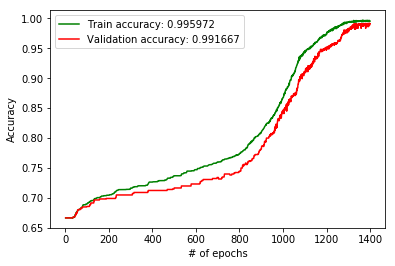

In [42]:
import matplotlib.pyplot as plt

train_accuracy = []
validation_accuracy = []

with open("stats.txt") as stats:
    for line in stats:
        line = line.rstrip()
        if "Train-accuracy" in line:
            index, accuracy = line.replace("Train-accuracy=", "").replace(" ", "").split(",")
            train_accuracy.append(float(accuracy))
        elif "Validation-accuracy" in line:
            index, accuracy = line.replace("Validation-accuracy=", "").replace(" ", "").split(",")
            validation_accuracy.append(float(accuracy))

epochs = range(1, 1401)

plt.plot(epochs, train_accuracy[:1400], 'g', epochs, validation_accuracy[:1400], 'r')
plt.legend(["Train accuracy: " + str(train_accuracy[1400]), "Validation accuracy: "+ str(validation_accuracy[1400])])
plt.xlabel("# of epochs")
plt.ylabel("Accuracy")
#plt.show()
plt.savefig('prediction_accuracy.png')

print get_game_prediction(model, encoder, "1. FC Köln", "FC Bayern")
print encoder.classes_